# Correlation analyses

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from tqdm.auto import tqdm
import sys
import os
import glob
import seaborn as sns
from scipy.stats import iqr

In [2]:
scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
study_sites_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/'
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

## Load snowlines, glacier boundaries, and ERA data

In [3]:
# -----Load snowlines
snowlines_path = os.path.join(scm_path, 'all_snowlines')
snowlines_fn = 'all_snowlines.csv'
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
snowlines.index = snowlines['datetime']

# -----Load glacier boundaries
aois_path = os.path.join(scm_path, 'all_AOIs')
aois_fn = 'all_aois.shp'
# load from file if it already exists
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)

# -----Load ERA data 
eras_path = os.path.join(scm_path, 'all_ERA_data')
eras_fn = 'all_era_data.csv'
# load from file if it already exists
eras = pd.read_csv(os.path.join(eras_path, eras_fn))    
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_78194/3493367648.py:4: DtypeWarning: Columns (13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))


## Calculate coefficients for AAR time series within subregions

Alaska Range


  0%|          | 0/29 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_AlaskaRange.csv


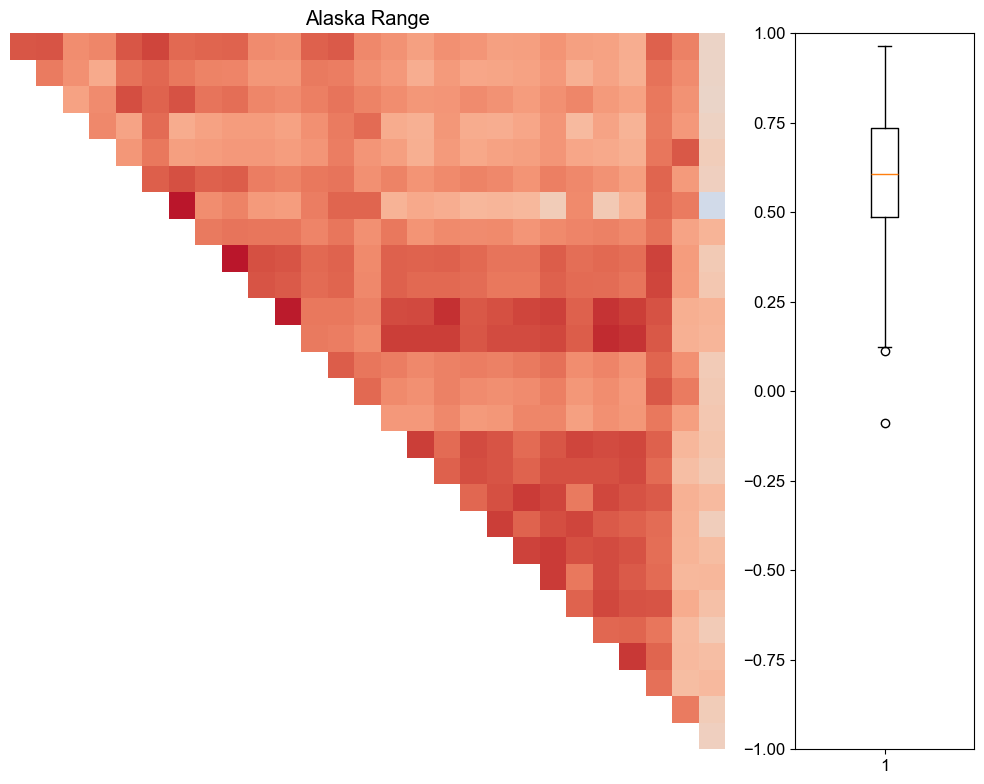

St. Elias Mtns.


  0%|          | 0/23 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_StEliasMtns.csv


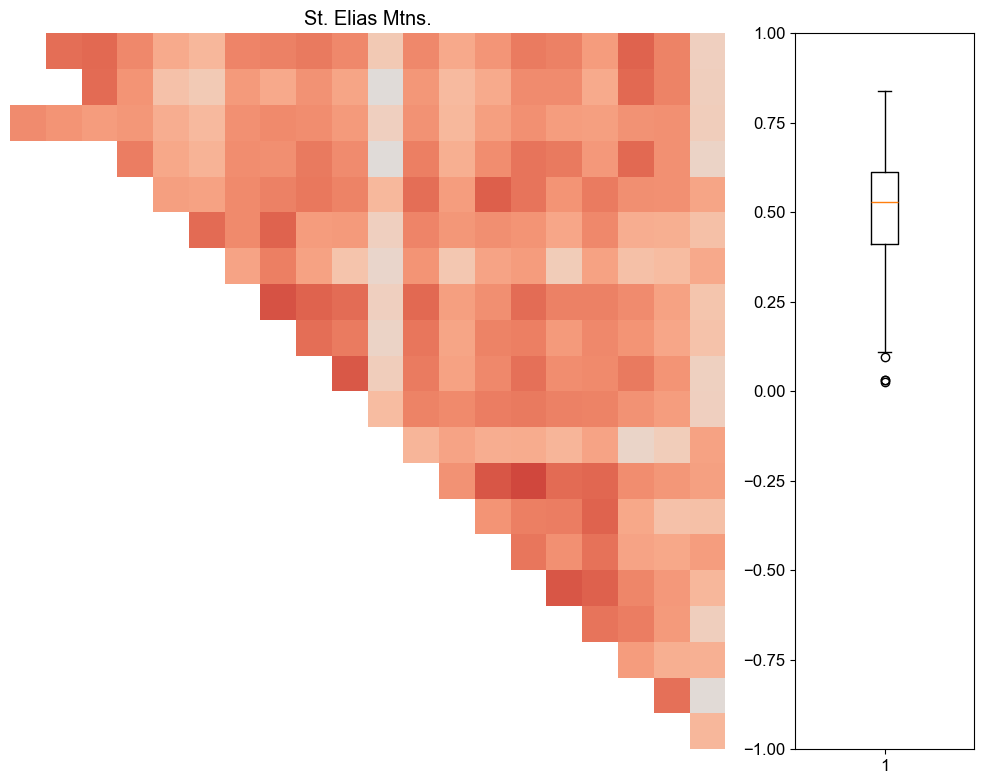

N. Coast Ranges


  0%|          | 0/24 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_NCoastRanges.csv


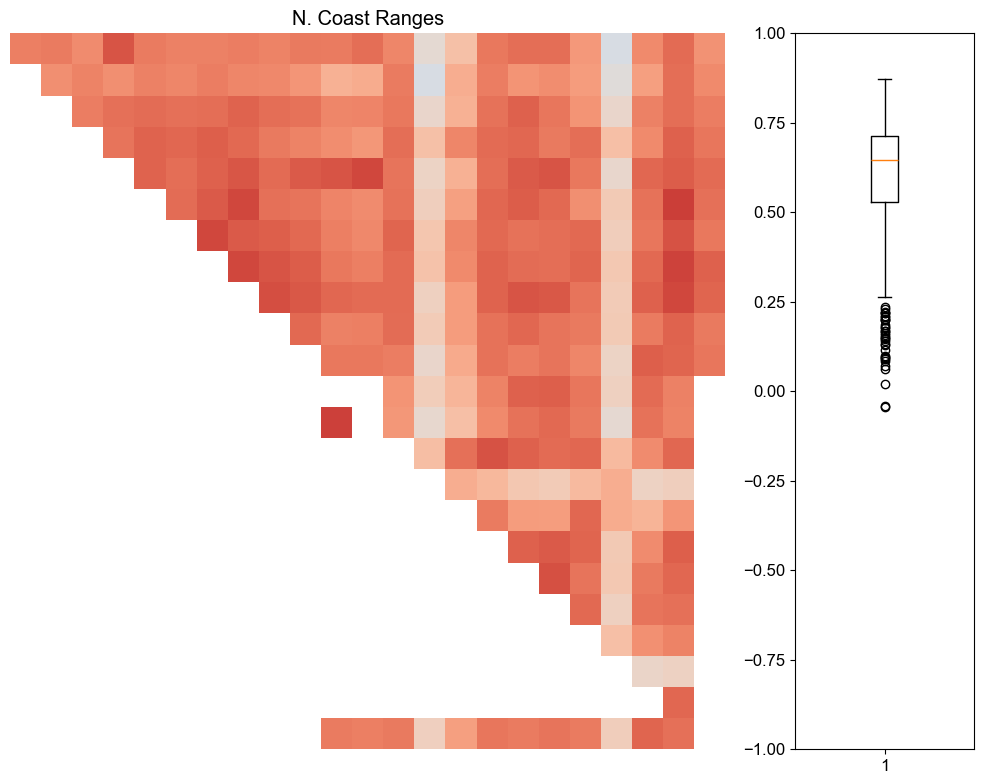

W. Chugach Mtns.


  0%|          | 0/18 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_WChugachMtns.csv


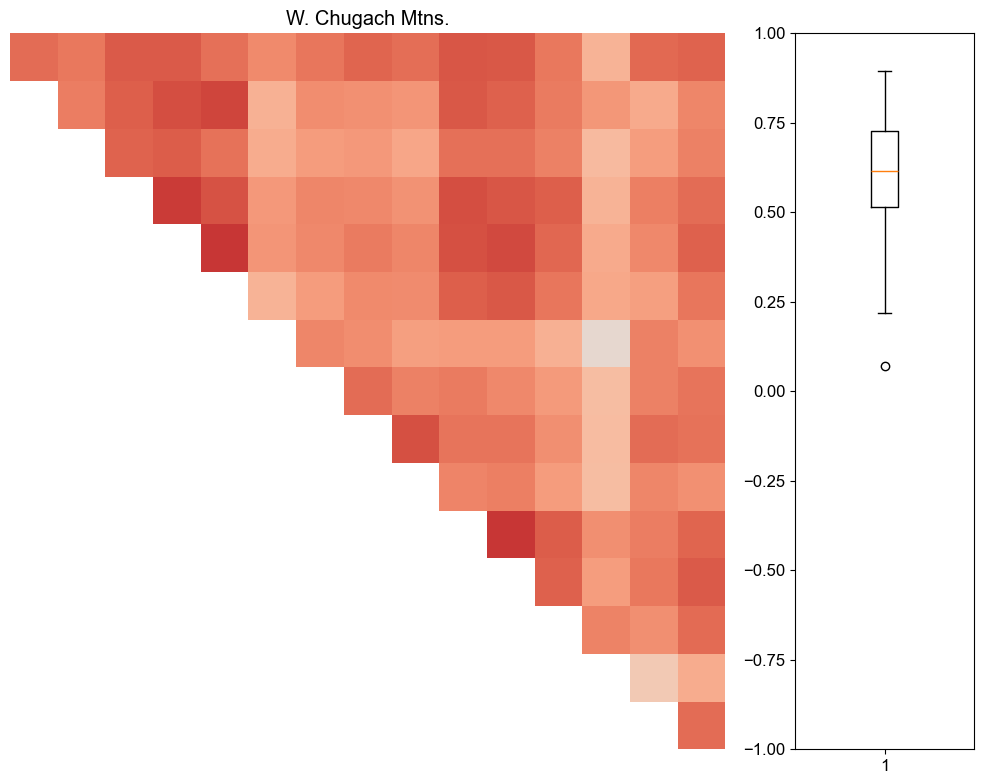

Aleutians


  0%|          | 0/27 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_Aleutians.csv


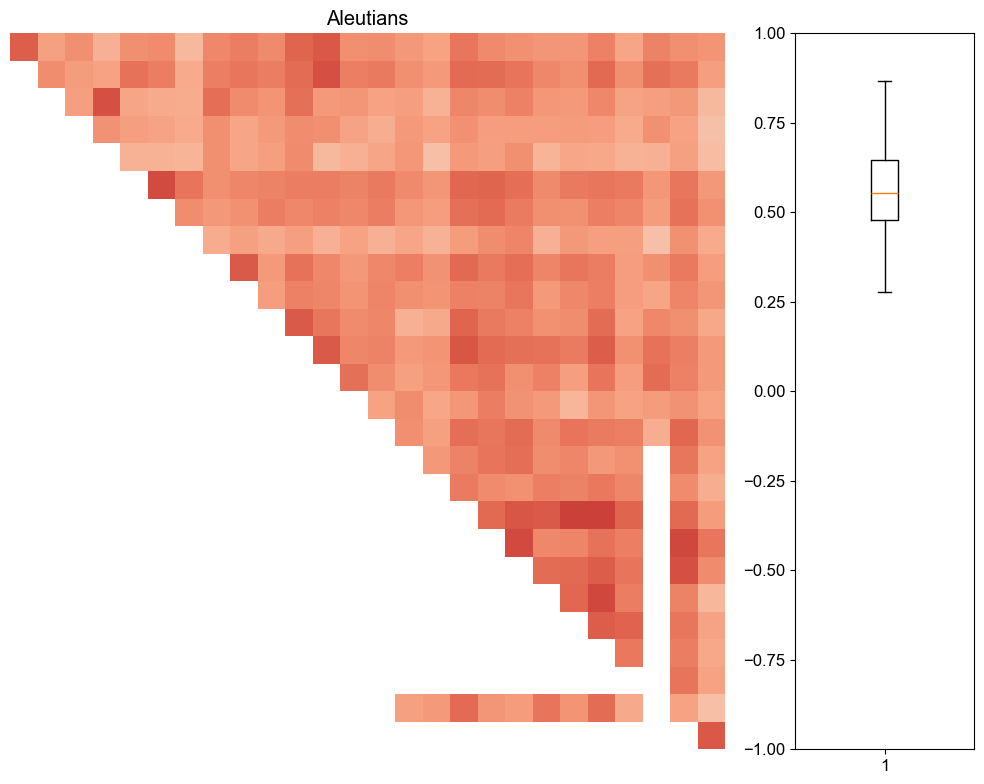

N. Cascades


  0%|          | 0/19 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_NCascades.csv


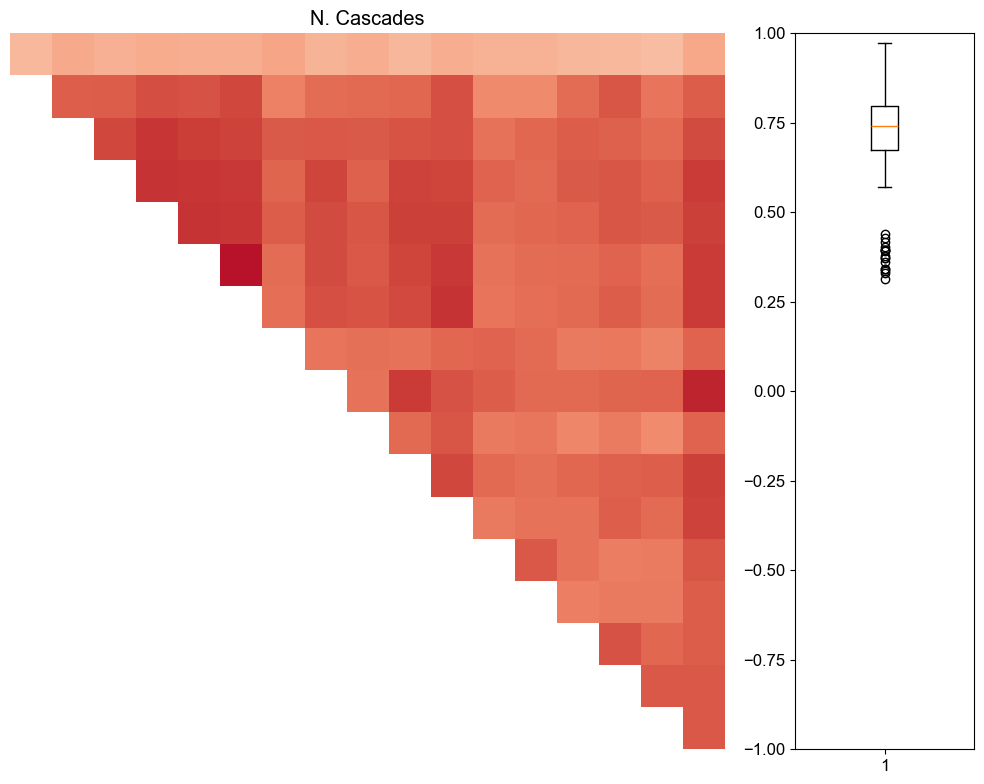

C. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_CRockies.csv


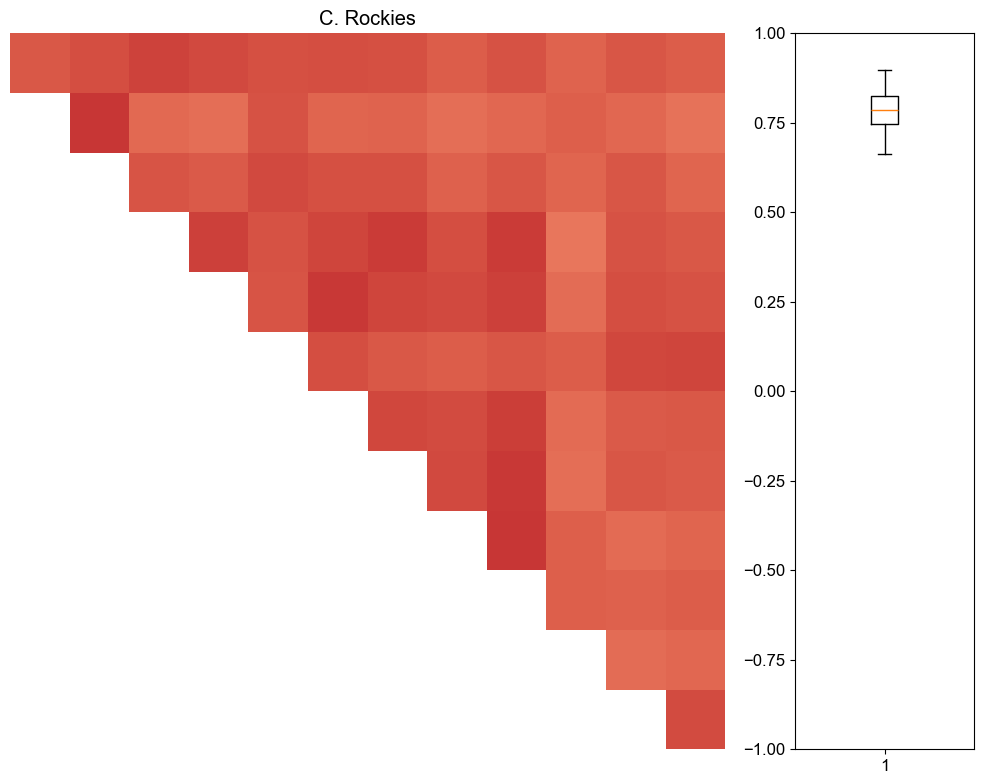

N. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_NRockies.csv


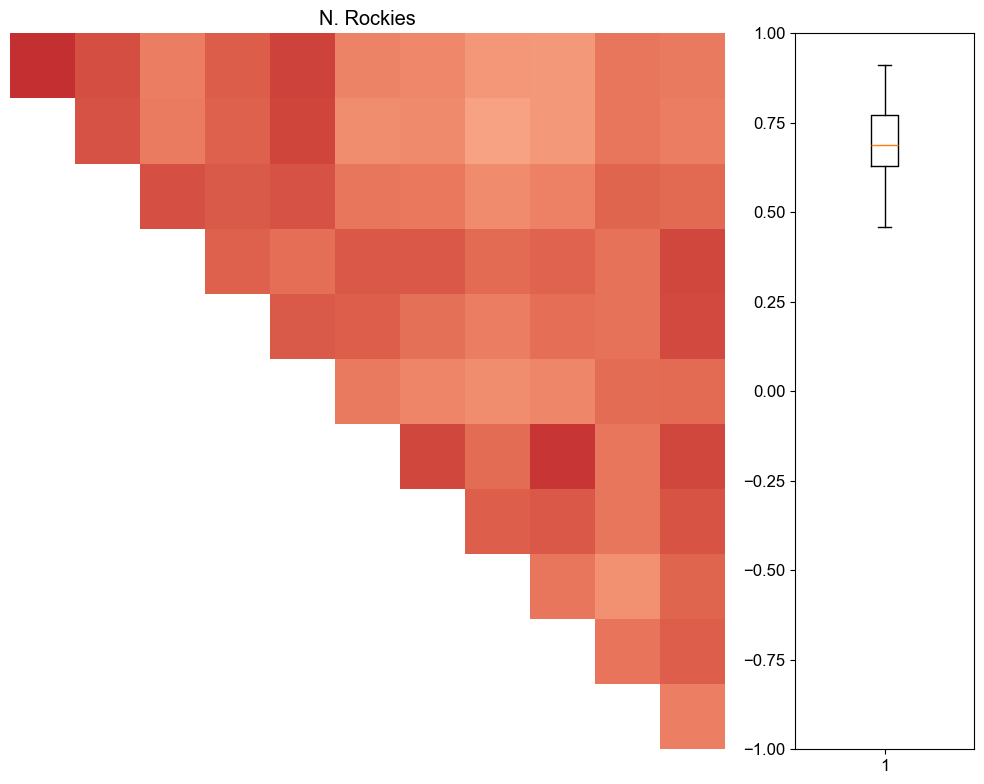

S. Cascades


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_SCascades.csv


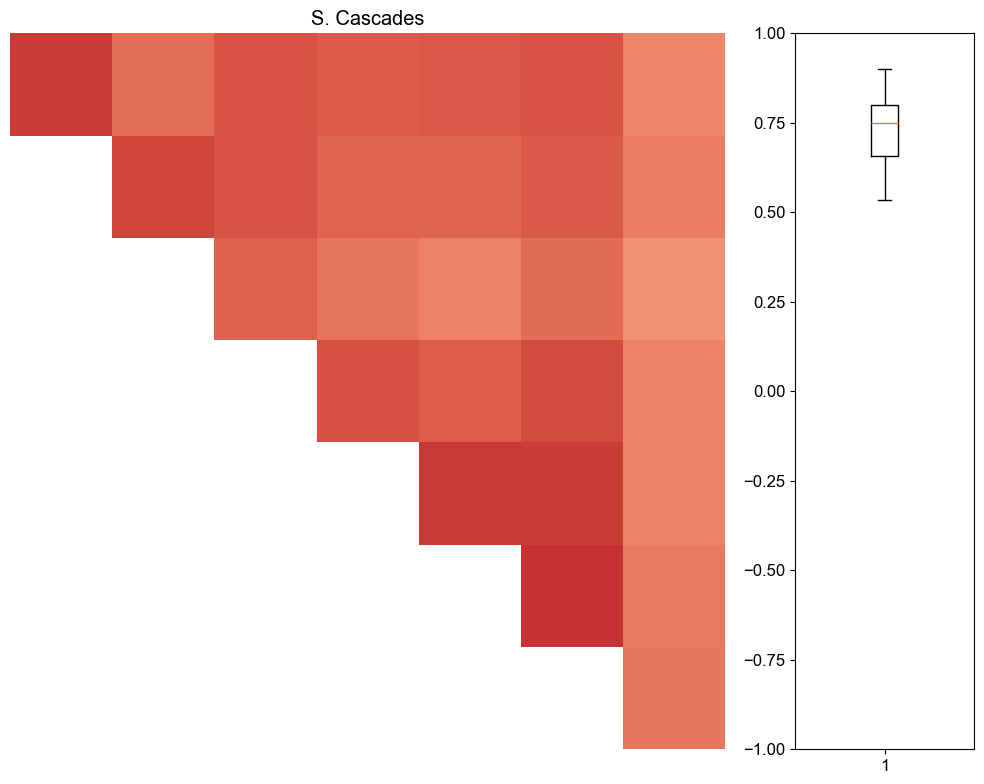

S. Rockies


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_snowlines/correlation_coefficients_SRockies.csv


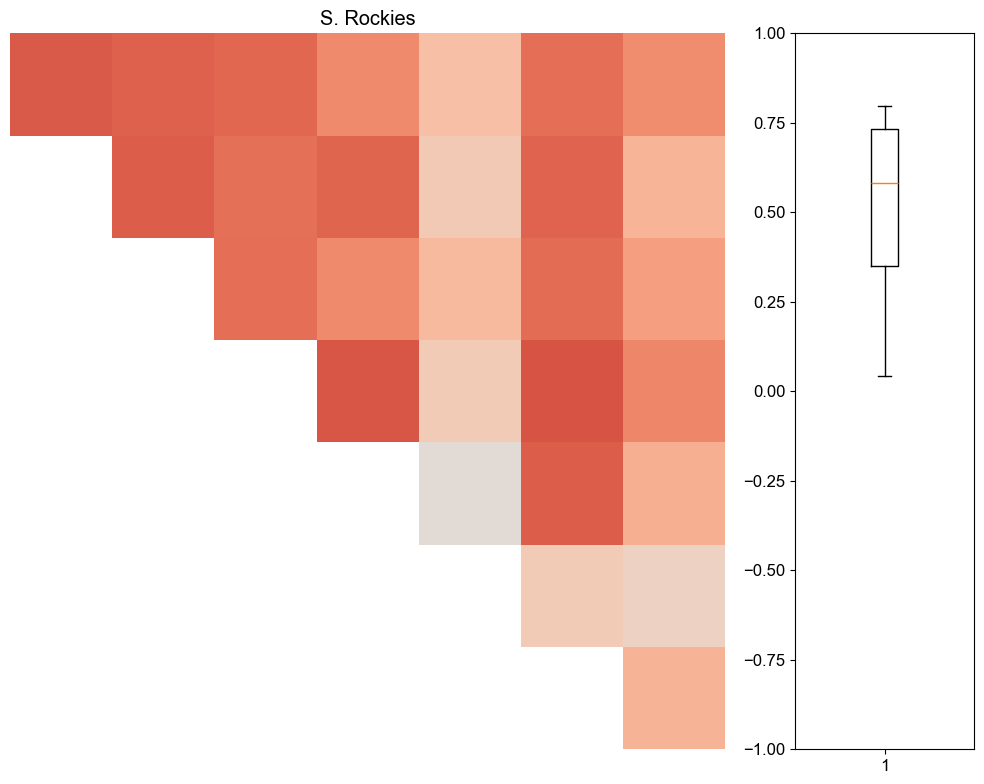

In [4]:
plt.rcParams.update({'font.size':12, 'font.sans-serif': 'Arial'})

# iterate over subregions
for o1region, o2region in aois[['O1Region', 'O2Region']].drop_duplicates().values:
    
    # identify subregion name and color for plotting
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # check if subregion correlations file already exists in file
    correlations_subregion_fn = 'correlation_coefficients_' + subregion_name.replace('.','').replace(' ','') + '.csv'
    if os.path.exists(os.path.join(snowlines_path, correlations_subregion_fn)):
        print('AAR correlations already exist in file, skipping...')
        continue

    # initialize dataframe for subregion correlation coefficients
    correlations_subregion = pd.DataFrame()

    # subset AOIs to subregion
    aois_subregion = aois.loc[(aois['O1Region']==o1region) & (aois['O2Region']==o2region)]

    # identify number of sites
    unique_site_names = aois_subregion['RGIId'].drop_duplicates().values

    # iterate over sites in subregion
    for i in tqdm(range(0, len(unique_site_names))):

        # grab site 1 time series
        site1_df = snowlines.loc[snowlines['site_name']==unique_site_names[i]]
        if len(site1_df) < 1:
            continue
        # remove duplicate dates, sort by date
        site1_df = site1_df[~site1_df.index.duplicated(keep='first')].sort_index()  

        # iterate over all other sites in subregion
        for j in range(i+1, len(unique_site_names)):
            
            # grab site 2 time series
            site2_df = snowlines.loc[snowlines['site_name']==unique_site_names[j]]
            if len(site2_df) < 1:
                continue
            # remove duplicate dates, sort by date
            site2_df = site2_df[~site2_df.index.duplicated(keep='first')].sort_index()  

            # resample both dataframes at a daily time interval
            site1_df = site1_df.resample('1D').bfill()
            site2_df = site2_df.resample('1D').bfill()
            min_date = np.min([site1_df.iloc[0]['datetime'], site2_df.iloc[0]['datetime']])
            max_date = np.max([site1_df.iloc[-1]['datetime'], site2_df.iloc[-1]['datetime']])
            site1_df = site1_df.loc[(site1_df['datetime'] >= min_date) & (site1_df['datetime'] <= max_date)]
            site2_df = site2_df.loc[(site2_df['datetime'] >= min_date) & (site2_df['datetime'] <= max_date)]

            # calculate correlation coefficient
            aar_correlation = pd.DataFrame({'Site1': site1_df['AAR'],
                                            'Site2': site2_df['AAR']}).corr().iloc[0,1]
            correlation_sites = pd.DataFrame({'Site1': [unique_site_names[i]],
                                              'Site2': [unique_site_names[j]],
                                              'AAR Corr. Coeff.': [aar_correlation]})
            # append to dataframe
            correlations_subregion = pd.concat([correlations_subregion, correlation_sites])

    # save CSV
    correlations_subregion_pivot = correlations_subregion.pivot_table(index='Site1', 
                                                                      columns='Site2', 
                                                                      values='AAR Corr. Coeff.')
    correlations_subregion_pivot.to_csv(os.path.join(snowlines_path, correlations_subregion_fn), index=False)
    print('Correlation coefficients saved to file: ', os.path.join(snowlines_path, correlations_subregion_fn))
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [4,1]})
    # heatmap
    sns.heatmap(correlations_subregion_pivot, ax=ax[0], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    ax[0].set_title(subregion_name)
    ax[0].set_xlabel('')
    ax[0].set_xticks([])
    ax[0].set_ylabel('')
    ax[0].set_yticks([])
    # boxplot
    ax[1].boxplot(correlations_subregion['AAR Corr. Coeff.'].values)
    ax[1].set_ylim(-1,1)
    fig.tight_layout()
    plt.show()


## Calculate correlation coefficients between AAR and cumulative PDD time series

In [5]:
# iterate over subregions
for i, (o1region, o2region) in enumerate(aois[['O1Region', 'O2Region']].drop_duplicates().values):
    
    # identify subregion name and color for plotting
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # check if subregion AAR-PDD correlations already exist in file
    correlations_subregion_fn = 'correlation_coefficients_aar-pdd_' + subregion_name + '.csv'
    if os.path.exists(os.path.join(eras_path, correlations_subregion_fn)):
        print('AAR-PDD correlations already exist in file, skipping...')
        continue
    
    # initialize dataframe for subregion correlation coefficients
    correlations_subregion = pd.DataFrame()

    # subset AOIs to subregion
    aois_subregion = aois.loc[(aois['O1Region']==o1region) & (aois['O2Region']==o2region)]

    # iterate over sites in subregion
    for site_name in tqdm(sorted(aois_subregion['RGIId'].drop_duplicates().values)):

        # grab site snowlines time series
        snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
        if len(snowlines_site) < 1:
            print('No snowlines for', site_name)
            continue
        # remove duplicate dates, sort by date
        snowlines_site = snowlines_site[~snowlines_site.index.duplicated(keep='first')].sort_index()  

        # grab ERA data for site
        era_site = eras.loc[eras['site_name']==site_name]
        if len(era_site) < 1:
            print('No ERA data for', site_name)
            continue
        era_site.index = era_site['Date']
        
        # resample both dataframes at a daily time interval
        snowlines_site = snowlines_site.resample('1D').bfill()
        era_site = era_site.resample('1D').bfill()
        min_date = np.min([snowlines_site.iloc[0]['datetime'], era_site.iloc[0]['Date']])
        max_date = np.max([snowlines_site.iloc[-1]['datetime'], era_site.iloc[-1]['Date']])
        snowlines_site = snowlines_site.loc[(snowlines_site['datetime'] >= min_date) & (snowlines_site['datetime'] <= max_date)]
        era_site = era_site.loc[(era_site['Date'] >= min_date) & (era_site['Date'] <= max_date)]

        # calculate correlation coefficient
        aar_pdd_correlation = pd.DataFrame({'site_name': snowlines_site['AAR'],
                                            'PDD_cumsum': era_site['Cumulative_Positive_Degree_Days']}).corr().iloc[0,1]
        correlation_site = pd.DataFrame({'Site': [site_name],
                                          'AAR-PDD Corr. Coeff.': [aar_pdd_correlation]})
        # append to dataframe
        correlations_subregion = pd.concat([correlations_subregion, correlation_site])

    # save CSV
    correlations_subregion.to_csv(os.path.join(eras_path, correlations_subregion_fn),index=False)
    print('Correlation coefficients saved to file: ', os.path.join(eras_path, correlations_subregion_fn))

    # print stats
    print('Correlation coefficients:')
    print('\t Mean:', np.nanmean(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t Std.:', np.nanstd(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t Median:', np.nanmedian(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t IQR:', iqr(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print(' ')
    
plt.show()


Alaska Range


  0%|          | 0/29 [00:00<?, ?it/s]

No snowlines for RGI60-01.22207
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_Alaska Range.csv
Correlation coefficients:
	 Mean: -0.11687743528477376
	 Std.: 0.1493370529621336
	 Median: -0.10825230206848092
	 IQR: nan
 
St. Elias Mtns.


  0%|          | 0/23 [00:00<?, ?it/s]

No snowlines for RGI60-01.13635
No snowlines for RGI60-01.14523
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_St. Elias Mtns..csv
Correlation coefficients:
	 Mean: -0.11315181189897595
	 Std.: 0.11169930610817141
	 Median: -0.12075117583182797
	 IQR: 0.10877848555138843
 
N. Coast Ranges


  0%|          | 0/24 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_N. Coast Ranges.csv
Correlation coefficients:
	 Mean: -0.18133656488965452
	 Std.: 0.07359242856280887
	 Median: -0.186386453254872
	 IQR: 0.091082898051492
 
W. Chugach Mtns.


  0%|          | 0/18 [00:00<?, ?it/s]

No snowlines for RGI60-01.09951
No snowlines for RGI60-01.10557
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_W. Chugach Mtns..csv
Correlation coefficients:
	 Mean: -0.21619326751310786
	 Std.: 0.09348694585000526
	 Median: -0.24295270821028345
	 IQR: 0.049020346119553415
 
Aleutians


  0%|          | 0/27 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_Aleutians.csv
Correlation coefficients:
	 Mean: -0.17289021130255652
	 Std.: 0.06694776694706685
	 Median: -0.1835228122710274
	 IQR: 0.08223374636854452
 
N. Cascades


  0%|          | 0/19 [00:00<?, ?it/s]

No snowlines for RGI60-02.05157
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_N. Cascades.csv
Correlation coefficients:
	 Mean: -0.2401940052886734
	 Std.: 0.03514744130782383
	 Median: -0.2365352436478324
	 IQR: 0.033285233147072935
 
C. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

No snowlines for RGI60-02.06585
No snowlines for RGI60-02.06859
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_C. Rockies.csv
Correlation coefficients:
	 Mean: -0.21059553122000946
	 Std.: 0.027155798306821285
	 Median: -0.19992028709138213
	 IQR: 0.04613806466548756
 
N. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

No snowlines for RGI60-02.12721
No snowlines for RGI60-02.12722
No snowlines for RGI60-02.13130
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_N. Rockies.csv
Correlation coefficients:
	 Mean: -0.10802654152481596
	 Std.: 0.05912704503145019
	 Median: -0.11418050697861587
	 IQR: 0.08319536225759605
 
S. Cascades


  0%|          | 0/9 [00:00<?, ?it/s]

No snowlines for RGI60-02.14297
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_S. Cascades.csv
Correlation coefficients:
	 Mean: -0.3362949474064738
	 Std.: 0.033752845806612676
	 Median: -0.34365998162401834
	 IQR: 0.02647234584379049
 
S. Rockies


  0%|          | 0/9 [00:00<?, ?it/s]

No snowlines for RGI60-02.16722
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/all_ERA_data/correlation_coefficients_aar-pdd_S. Rockies.csv
Correlation coefficients:
	 Mean: -0.26553787156295355
	 Std.: 0.08291976645251896
	 Median: -0.26231160479205406
	 IQR: 0.15204107644147505
 
